Data provided hold the historical records of Opportunities (a potential deal with client). Opportunity is presented by the following (main) columns (properties): OpportunityId - to identify a separate Opportunity uniquely, CreatedDate - the date of the record creation, StageName - probability and the short stage description for a successful deal closing (100% Opportunity) Amount - (a current corrected version of) sum of the (potential) deal // ??? CloseDate - forecasted deal closing date Probability - the probability of success for this opportunity at its current stage other fields - properties of the Opportunity

You have the history of interactions with clients (Opportunity is a potential deal).
You should forecast the Probability of successful deal (Opportunity) closing.
Speaking more precisely, to forecast most likely next Probability using the known previous history for this Opportunity (potential deal), namely Stage + Probability changes in previous time.
Also you could use available properties of that Opportunity

In [7]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

print(tf.__version__)

2.8.0


In [8]:
df = pd.read_csv("test_data_full.csv")

In [9]:
missing_values_count = df.isnull().sum()
missing_values_count

Unnamed: 0                            0
Id                                    0
OpportunityId                         0
CreatedById                           0
CreatedDate                           0
CreatedDateForInsert                  0
StageName                             0
Amount                                0
Probability                           0
PrevOpportunityStageUpdate            0
ValidThroughDate                    927
SystemModstamp                        0
IsDeleted                             0
PrevAmount                         3843
PrevCloseDate                      3741
AccountId                             0
RecordTypeId                        216
StageSortOrder                        0
Type                                  0
LeadSource                          681
CampaignId                            0
OwnerId                               0
Territory2Id                          0
FiscalYear                            0
FiscalQuarter                         0


In [10]:
data = df[df['StageName'].str.contains('100%') | df['StageName'].str.contains('0% prob')]

data.StageName = data.StageName.apply(lambda x: '1' if '100' in x else '0')

C:\Users\Bohdan Potuzhnyi\AppData\Local\Temp\ipykernel_20848\1709562736.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.StageName = data.StageName.apply(lambda x: '1' if '100' in x else '0')


In [11]:
series = data.groupby("OpportunityId").OpportunityId.count()
series.sort_values(inplace=True)
series.head(700)

OpportunityId
0061300001KIkjMAAT    1
0061B00001RMeAjQAL    1
0061300001HidygAAB    1
0061300001HjfPrAAJ    1
0061300001FVMHDAA5    1
                     ..
0064v00001q6b2XAAQ    8
0063000000DI4dZAAT    8
0064v00001s7BDYAA2    8
0061B00001c2JpRQAU    8
0061B00001ZG7GcQAL    8
Name: OpportunityId, Length: 700, dtype: int64

In [15]:
opp_id = "0061B00001c2JpRQAU"
specific_opportinity = data.loc[(data.OpportunityId == opp_id)]
status = (specific_opportinity.loc[specific_opportinity.index[0], 'StageName'] == '1')
# 1-success
# 0-failure

print(status)
specific_opportinity = specific_opportinity.sort_values(by="CreatedDateForInsert", ascending=True)
specific_opportinity

start_date = specific_opportinity.loc[specific_opportinity.index[0], "CreatedDate"]
start_date = datetime.strptime(start_date, '%m/%d/%Y %H:%M')

res_arr = []
arr = []
i = 0
for current in specific_opportinity["CreatedDateForInsert"]:
    current_date = datetime.strptime(current, '%Y-%m-%d %H:%M:%S')
    res_arr.append(int((current_date - start_date).total_seconds()))
    if i == 0:
        arr.append(int((current_date - start_date).total_seconds()))
        i+=1
    else:
        arr.append(int((current_date - start_date).total_seconds()) - arr[i-1])
        i+=1
    
specific_opportinity = specific_opportinity.loc[:, ["CreatedById", "Amount", "Probability"]]
specific_opportinity.insert(3, "Duration", res_arr)
specific_opportinity.insert(4, "DeltaDUration", arr)

True


In [16]:
specific_opportinity.drop_duplicates(subset=['Duration'], inplace=True)
specific_opportinity

,CreatedById,Amount,Probability,Duration,DeltaDUration
1701,0051B00000CkrTGQAZ,7200.0,80,0,0
1710,0051B00000CkrTGQAZ,7200.0,80,495600,495600
2528,0051B00000CkrTGQAZ,7200.0,80,32124780,31629180
2560,0051B00000CkrTGQAZ,7200.0,80,33401160,1771980
2561,0051B00000CkrTGQAZ,7200.0,80,33401280,31629300
2562,0051B00000CkrTGQAZ,7200.0,100,33402000,1772700
3876,0051B00000CkrTGQAZ,7200.0,100,63236760,61464060
3877,0051B00000CkrTGQAZ,7200.0,100,63237060,1773000


<AxesSubplot:>

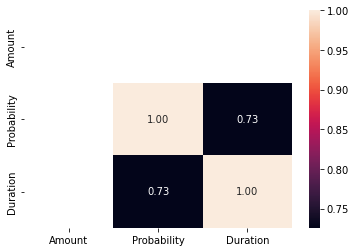

In [34]:
sns.heatmap(specific_opportinity.corr('pearson'), annot=True, fmt='.2f')

In [25]:
#sns.barplot(x="Duration", y="Probability", data=specific_opportinity)
#sns.scatterplot(x="Duration", y="Probability", data=specific_opportinity)

regressor = RandomForestRegressor(n_estimators=500, random_state=0)

score ->  0.9387946666666668


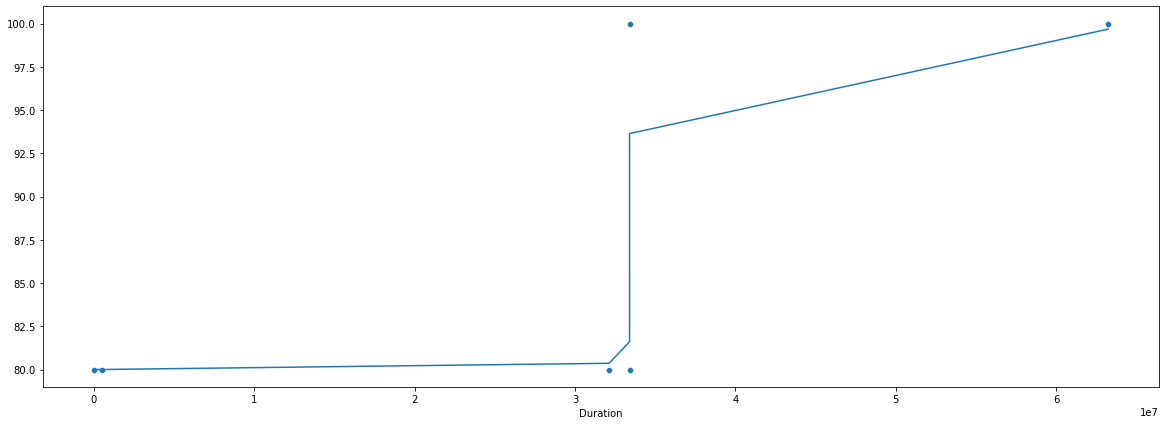

In [35]:
plt.figure(figsize=(20,7))
X = specific_opportinity['Duration'].values[:,np.newaxis]
# target data is array of shape (n,) 
y = specific_opportinity['Probability'].values

regressor.fit(X, y)

y_prediction_forest = regressor.predict(X)
sns.scatterplot(x=specific_opportinity['Duration'], y = y)
sns.lineplot(x=specific_opportinity['Duration'], y = y_prediction_forest)

print('score -> ', regressor.score(X, y))